In [1]:
import numpy as np
import Project.unicycle
from Project.unicycle import from_polar_to_cartesian, from_cartesian_to_polar
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib
import Project.cubicpath as cubicpath
#Magic to enable matplotlib widgets
%matplotlib inline
plt.rcParams['figure.figsize'] = [10*2/2.54, 8*2/2.54]
matplotlib.rcParams['figure.dpi']=160

In [2]:

# Posture Regulation
class UnicycleControl:
    def __init__(self):
        self.sol = None
        self.q = None
        self.t = None
        self.q0 = None
        self.goal = None
        self.v = None
        self.w = None
        self.sim_args = None
        self.x_d = None
        self.y_d = None
        self.theta_d = None
        self.w_d = None
        self.v_d = None
        self.v_arr = []
        self.w_arr = []

    def control(self, *args):
        v = self.control_v(args)
        w = self.control_w(args)
        self.v_arr.append(v)
        self.w_arr.append(w)
        return v, w

    def set_simulation_args(self, args):
        self.sim_args = args

    def get_simulation_args(self):
        return self.sim_args

    def control_v(self, *args):
        pass
    def set_goal(self, goal):
        self.goal = goal

    def control_w(self, *args):
        pass

    def animation(self):
        pass

    def postprocess(self, *args):
        pass

    def get_time(self):
        return self.t

    def set_time(self, t):
        self.t = t

    def set_initial_conditions(self, q0):
        self.q0 = q0

    def get_initial_conditions(self):
        return self.q0

    def dynamics(self, q, t, args):
        pass

    def run_simulation(self):
        q0 = self.get_initial_conditions()
        t = self.get_time()
        args = self.get_simulation_args()
        if q0 is None or t is None:
            print('Error: the intial conditions are not set.')
            raise ValueError

        if args is None:
            q = odeint(self.dynamics, q0, t)
        else:
            q = odeint(self.dynamics, q0, t, args)

        self.sol = q

    def plot_xy(self):
        plt.figure()
        plt.plot(self.sol[0,0],self.sol[0,1],'g',marker='x',markersize =12)
        plt.plot(self.sol[:,0], self.sol[:,1], 'b')
        plt.grid()
        plt.xlabel(r'$x$')
        plt.ylabel(r'$y$')
        plt.show()

    def get_x(self):
        return self.sol[:,0]

    def get_y(self):
        return self.sol[:,1]

    def get_theta(self):
        return self.sol[:,2]

    def get_v(self):
        len_v = len(self.v_arr)
        len_t = len(t)
        if len_v < len_t:
            diff = len_t-len_v # len new vect to add
            vec_v = self.v_arr[-1]*np.ones(diff)
            return np.concatenate((np.array(self.v_arr),vec_v),axis=None)
        elif len_v == len_t:
            return self.v_arr
        elif len_v > len_t:
            return self.v_arr[0:len_t]
    def get_w(self):
        len_w = len(self.w_arr)
        len_t = len(t)
        if len_w < len_t:
            diff = len_t-len_w # len new vect to add
            vec_w = self.w_arr[-1]*np.ones(diff)
            return np.concatenate((np.array(self.w_arr),vec_w),axis=None)
        elif len_w == len_t:
            return self.w_arr
        elif len_w > len_t:
            return self.w_arr[0:len_t]


In [6]:
class CartesianRegulator(UnicycleControl):
    def __init__(self,k_1,k_2):
        super(CartesianRegulator,self).__init__()
        self.k_1 = k_1
        self.k_2 = k_2
        self.path = None


    def control_v(self, *args):
        x, y, theta,x_d,y_d,theta_d = args[0]
        e_x = -x_d+x
        e_y = -y_d+y
        e_theta = -theta_d+theta

        k_1 = self.k_1
        v = -k_1 * ( e_x * np.cos(e_theta) + e_y * np.sin(e_theta))
        return v

    def control_w(self, *args):
        x, y, theta,x_d,y_d,theta_d = args[0]
        e_x = -x_d+x
        e_y = -y_d+y
        e_theta = -theta_d+theta
        k_2 = self.k_2
        w = k_2 * (np.arctan2(e_y,e_x) + np.pi - e_theta)

        return w

    def dynamics(self, q, t,*args):

        x = q[0]
        y = q[1]
        theta = q[2]
        path, time = args
        self.path = path

        T = np.searchsorted(time,t)
        if (T>=len(time)):
            T = len(time)-1

        x_d= path[0]['x'][T]
        y_d = path[0]['y'][T]
        theta_d = path[0]['theta'][T]


        # v = self.control_v(q)
        # w = self.control_w(q)
        v, w = self.control( x, y, theta,x_d,y_d,theta_d )
        dotx = v * np.cos(theta)
        doty = v * np.sin(theta)
        dottheta = w


        return np.array([dotx, doty, dottheta])

    def compute_control_1_odeint(self, t, k):
        waypoints = np.array([[0., 0., 0.], [10, 10, 0]])
        self.path = cubicpath.compute_path_from_waypoints(waypoints, k, t)
        self.robot_states = odeint(self.model_1, np.array(self.start_position), t,
                                   args=(self.path, t))
        return self.robot_states

    def plot_xy(self):
            plt.figure()
            plt.plot(self.sol[0,0],self.sol[0,1],'g',marker='x',markersize =12)
            plt.plot(self.sol[:,0], self.sol[:,1], 'b')
            plt.plot(self.path[0]['x'],self.path[0]['y'])
            plt.grid()
            plt.xlabel(r'$x$')
            plt.ylabel(r'$y$')
            plt.show()





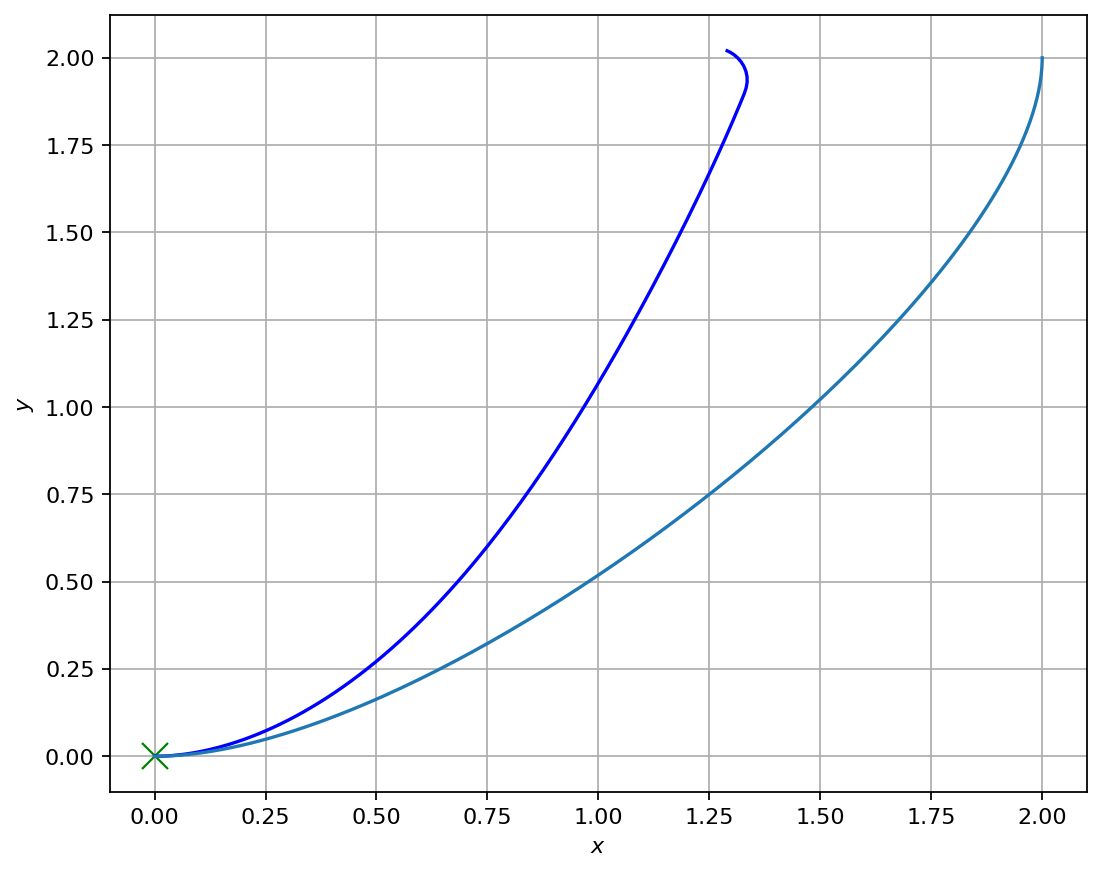

In [7]:
# Simulation
q0 = np.array([0, 0, 0])
qgoal = [0,0,0]
t = np.linspace(0, 10, 200)

waypoints = np.array([[0., 0., 0.], [2, 2, np.pi/2]])
path = cubicpath.compute_path_from_waypoints(waypoints, 2)
args = (path, t)

k_1 = 0.5
k_2 = 0.5
c = CartesianRegulator(k_1,k_2)
c.set_simulation_args(args)
#c.set_goal(goal=qgoal)
c.set_time(t) # sets the simulation time
c.set_initial_conditions(q0) # sets the initial conditions
c.run_simulation()
c.plot_xy()



In [41]:
c.goal



[2.0, 2.0, 1.5707963267948966]

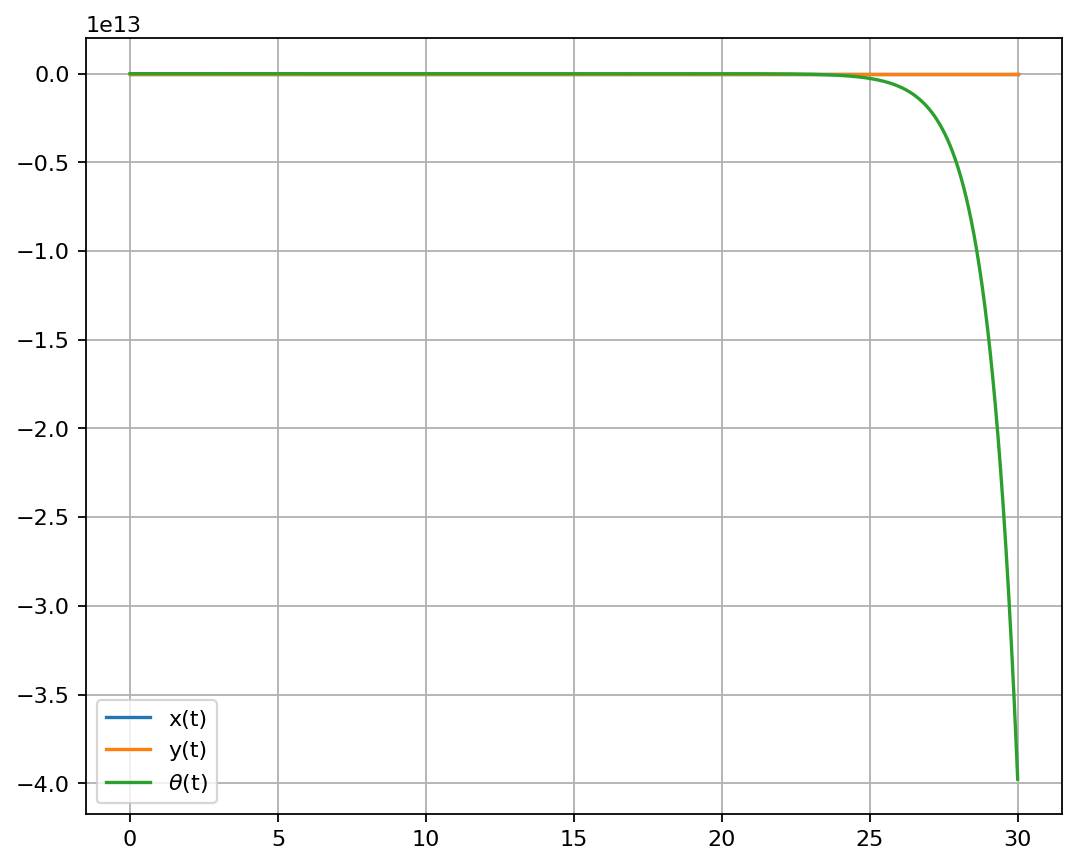

In [39]:
# Plot the state dynamics
x = c.get_x()
y = c.get_y()
theta = c.get_theta()
plt.plot(t, x)
plt.plot(t, y)
plt.plot(t, theta)
plt.grid()
plt.legend(['x(t)','y(t)',r'$\theta$(t)'])


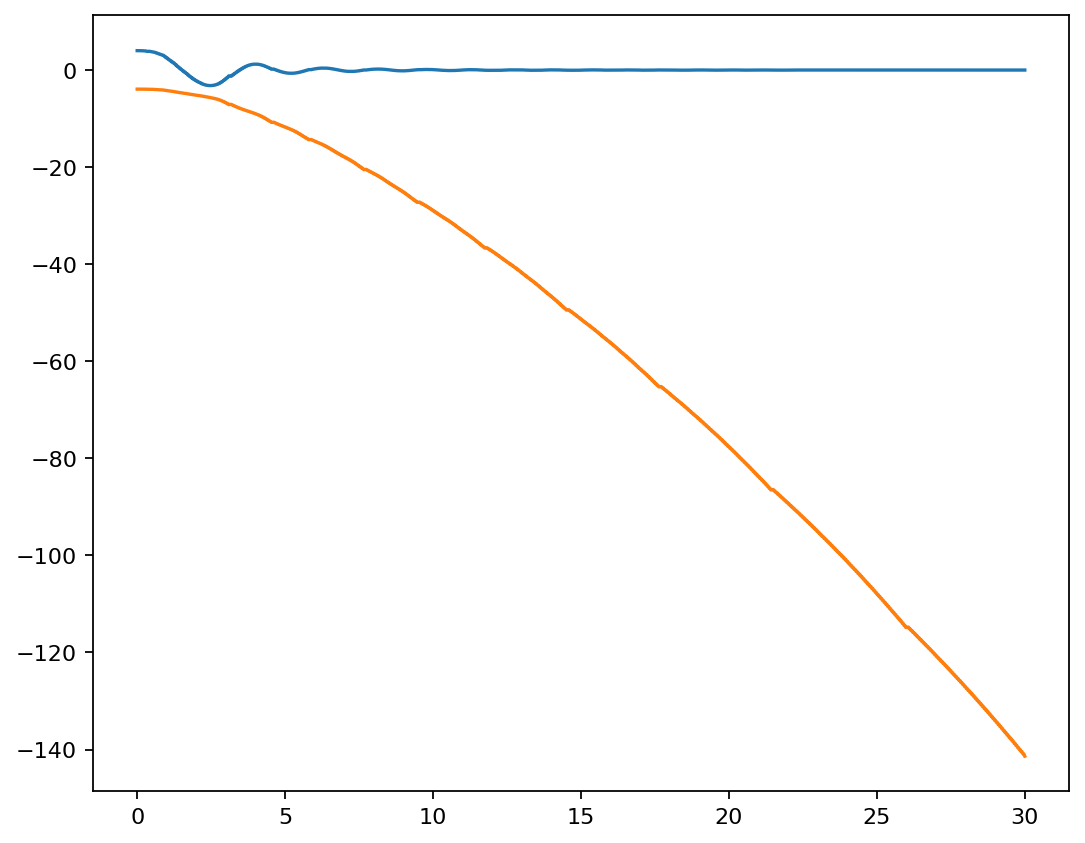

In [40]:
# Plot the control effort
plt.plot(t,c.get_v())
plt.plot(t,c.get_w())
#c.w_arr[:100]

In [41]:
class PolarRegulator(UnicycleControl):
    def __init__(self, k_1, k_2, k_3):
        super(PolarRegulator, self).__init__()
        self.k_1 = k_1
        self.k_2 = k_2
        self.k_3 = k_3


    def control_v(self, *args):
        (rho, delta, gamma) = args[0]
        k_1 = self.k_1
        e_rho = -self.goal[0]+rho
        e_delta = -self.goal[1]+delta
        e_gamma = -self.goal[2]+gamma
        v = k_1 * e_rho * np.cos(e_gamma)
        return v


    def control_w(self, *args):
        (rho, delta, gamma) = args[0]
        k_1 = self.k_1
        k_2 = self.k_2
        k_3 = self.k_3
        e_rho = -self.goal[0]+rho
        e_delta = -self.goal[1]+delta
        e_gamma = -self.goal[2]+gamma
        w = k_2*e_gamma + k_1 * ((np.sin(e_gamma)*np.cos(e_gamma))/e_gamma) * (e_gamma + k_3*e_delta)
        return w

    def dynamics(self, q, t):
        rho = q[0]
        delta = q[1]
        gamma = q[2]

        v, w = self.control(rho,delta,gamma)
        dot_rho = -v * np.cos(gamma)
        dot_delta = v/rho * np.sin(gamma)
        dot_gamma = v/rho *np.sin(gamma) - w
        return np.array([dot_rho, dot_delta, dot_gamma])


    def get_x(self):
        if self.sol is not None:
            return [ q[0]*np.cos(q[1]+np.pi) for q in self.sol]
        else:
            raise ValueError


    def get_y(self):
        if self.sol is not None:
            return [ q[0]*np.sin(q[1]+np.pi) for q in self.sol]
        else:
            raise ValueError

    def get_theta(self):
        if self.sol is not None:
            return [ np.arctan2(np.sin(q[1]-q[2]),np.cos(q[1]-q[2])) for q in self.sol]
        else:
            raise ValueError

    def postprocess(self):
        #for i in np.arange(0, len(self.time)):
        pass


    def from_cartesian_to_polar(self,q):
        x = q[0]
        y = q[1]
        theta = q[2]
        rho = np.sqrt(x**2 + y**2)
        gamma = np.arctan2(y, x) - theta + np.pi
        delta = gamma + theta
        return rho, delta, gamma

    def from_polar_to_cartesian(self, p):
        rho = p[0]
        gamma = p[1]
        delta = p[2]
        x = rho * np.cos(delta + np.pi)
        y = rho * np.sin(delta + np.pi)
        theta = delta - gamma
        return x, y, theta

    def plot_xy(self):
        plt.figure()
        plt.plot(self.get_x()[0],self.get_y()[0],'g',marker='x',markersize =12)
        plt.plot(self.get_x(), self.get_y(), 'b')
        plt.grid()
        plt.xlabel(r'$x$')
        plt.ylabel(r'$y$')
        plt.show()



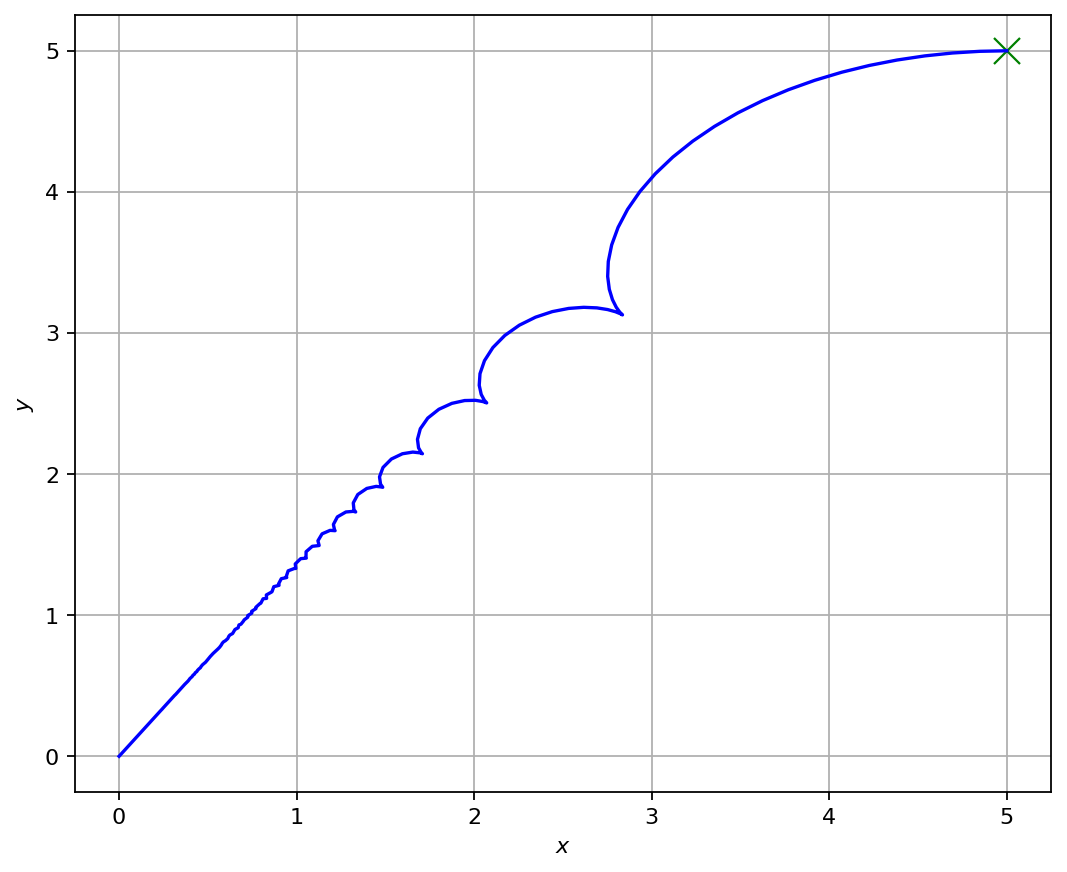

In [52]:
q0 = np.array([5, 5, np.pi])
t = np.linspace(0,30,1000)
p = PolarRegulator(-1,-1,-1)
p.set_goal(p.from_cartesian_to_polar([0,0,0]))
p.set_time(t)
p.set_initial_conditions(p.from_cartesian_to_polar(q0))
p.run_simulation()
p.plot_xy()

In [47]:
q = p.from_cartesian_to_polar([5,2,0])
p.from_polar_to_cartesian(q)

(5.0, 1.9999999999999987, 0.0)

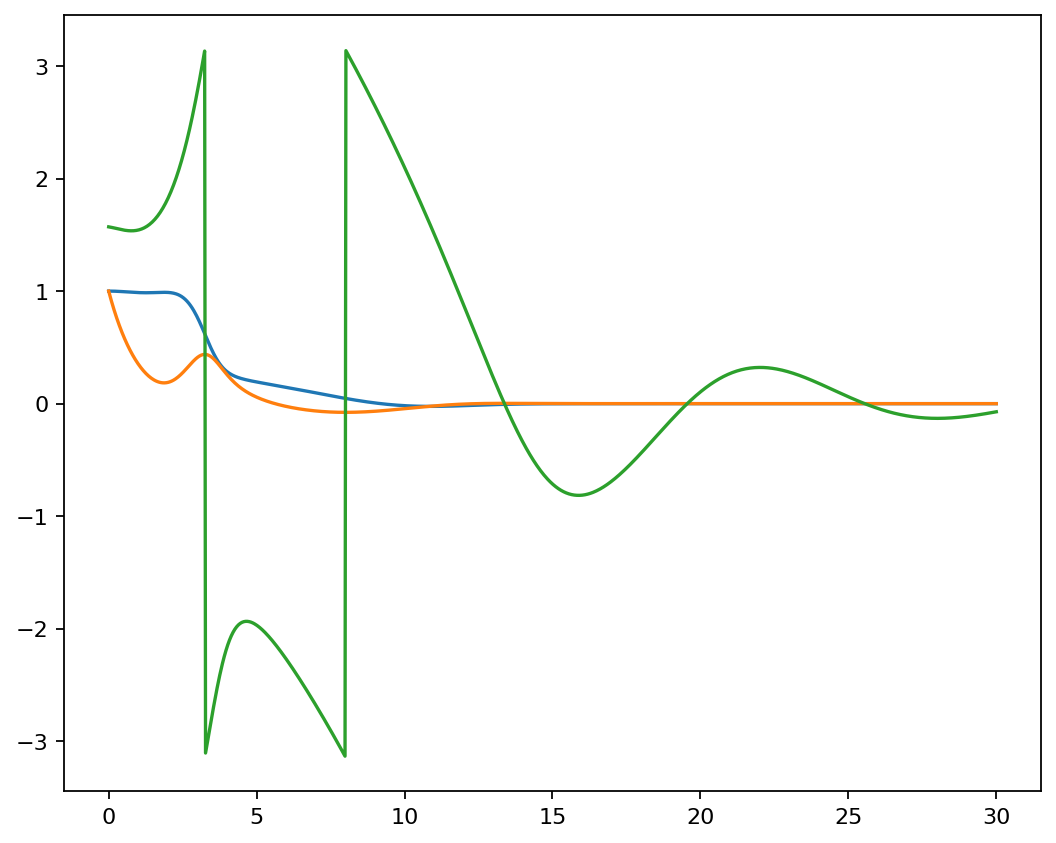

In [16]:
plt.plot(p.get_time(),p.get_x())
plt.plot(p.get_time(),p.get_y())
plt.plot(p.get_time(),p.get_theta()) # notice theta is in [-pi, pi]


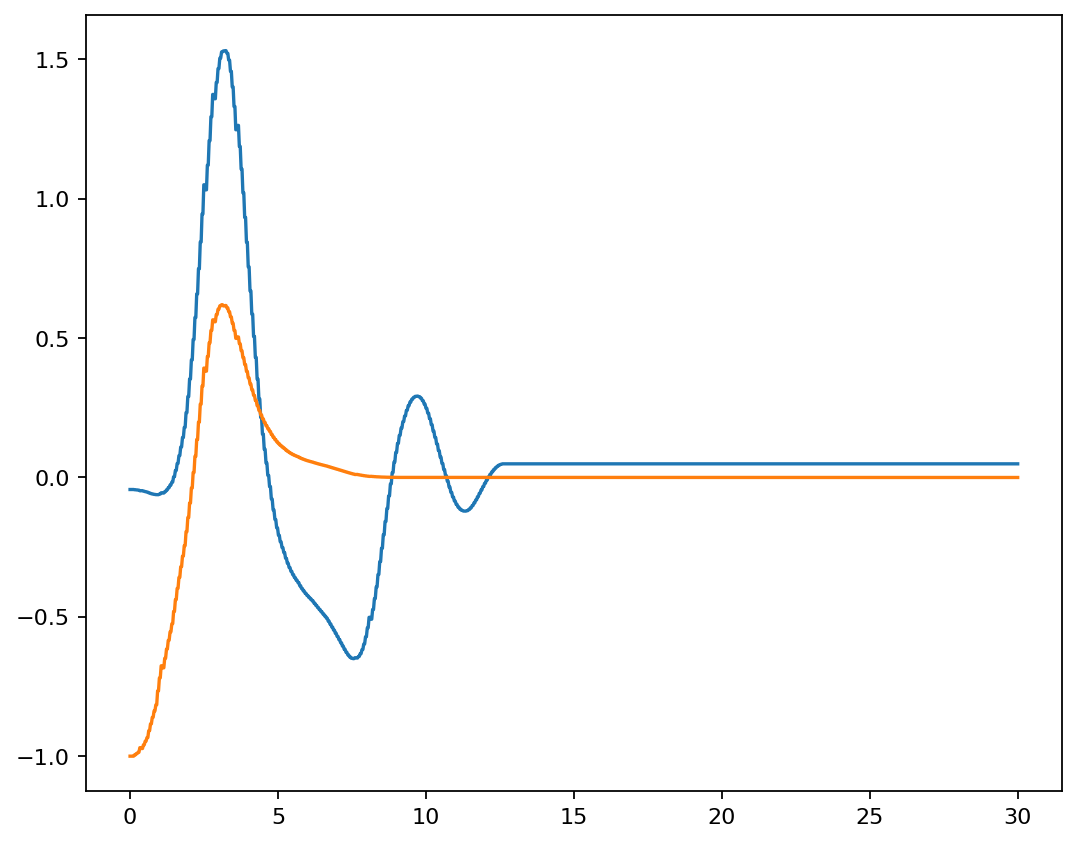

In [17]:
# Plot the control effort
plt.plot(t,p.get_w())
plt.plot(t,p.get_v())